In [1]:
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import random
import time as time
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.svm import SVC

from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

# to calculate the performance of the models
from sklearn.metrics import matthews_corrcoef

##### Create RF models using grid combination of hyperparameters

In [2]:
rf_params = {'n_estimators':100,
            'random_state':13}

n_estimator = [*range(20, 200, 40)]
print(n_estimator)

rf_grid_params = {'n_estimators':n_estimator,
            'random_state':[13]}

def get_RF_models():
    models = list()
    RF_params_base = list()
    for n in rf_grid_params['n_estimators']:
        rf_params = {'n_estimators': n,
                    'max_features':None,
                    'random_state': 13}
        models.append(RandomForestClassifier(**rf_params))
        RF_params_base.append(rf_params)
    return models, RF_params_base

[20, 60, 100, 140, 180]


In [3]:
#get model
RF_models, RF_params = get_RF_models()
print(len(RF_params))

5


In [44]:
path = '/Users/hek/Research/Cheminformatics/Project_1_NPS/Stimulant vs. Hallucinogens/Dataset/Bioassay data/ChEMBL data/'
output_path = '/Users/hek/Research/Cheminformatics/Project_1_NPS/Stimulant vs. Hallucinogens/ChEMBL Dataset ML results/'
df_model_list = pd.read_excel(path+"Target - Assays - Model list.xlsx")
df_model_list_result = pd.read_csv(path+"Target - Assays - Model list and results.csv")

##### Generate fingerprints from SMILES

In [8]:
def load_ChEMBL_data(filename):
    df = pd.read_csv(path+filename,dtype="object")
    print("Shape of dataframe: ", df.shape)
    return df

In [22]:
def get_X_Y(df,method="maccsfp"):
    Y = df.active
    total = []
    for i in range(df.shape[0]):
        b = [int(i) for i in list(df.loc[i,method])]
        total.append(b)
    X_df = pd.DataFrame(total)
    
    return X_df, Y

In [9]:
def tenfold_split(X_df,Y,df):

    kf = KFold(n_splits =10, shuffle=True, random_state=42)

    X_train_base, X_test_base, Y_train_base, Y_test_base = [],[],[],[]
    for train_index, test_index in kf.split(df):
        X_train, X_test = X_df.iloc[train_index,:], X_df.iloc[test_index,:]
        Y_train, Y_test = Y[train_index], Y[test_index]  
    
        X_train_base.append(X_train)
        X_test_base.append(X_test)
        Y_train_base.append(Y_train)
        Y_test_base.append(Y_test)
        
    return X_train_base, X_test_base, Y_train_base, Y_test_base

In [7]:
def base_model(model):
    MCC_base = []
    for i in range(10):
        # Select training and test dataset and class label of the test set
        print("Fold ", i+1)
        X_train = X_train_base[i]
        Y_train = Y_train_base[i]
        X_test = X_test_base[i]
        Y_test = np.array(Y_test_base[i])
        
        model_obj = model.fit(X_train,Y_train)
        Y_pred = model_obj.predict(X_test)
        
        MCC = matthews_corrcoef(Y_test, Y_pred)
        MCC_base.append(MCC)
        i = i+1
        
    return np.array(MCC_base)

def grid_CV(models, params):
    tinit = time.time()
    score_tracker = []
    print("Total of ", len(models)*10,"runs")
    n = 1
    for i in range(len(models)):
        params[i]['MCC'] = base_model(models[i]).mean()
        score_tracker.append(params[i])
        print("Grid search model parameter ",n,"done")
        n = n + 1
    tfinal = time.time()
    print('Done!')
    print('Time required for',len(models)*10,'runs grid search:', tfinal-tinit, 'seconds')
    #print("Best model:")
    #print(sorted(score_tracker, key=lambda x: x['MCC'], reverse=True)[0])
    best_model = sorted(score_tracker, key=lambda x: x['MCC'], reverse=True)[0]
    return best_model

In [ ]:
#get model
RF_models, RF_params = get_RF_models()
method="maccsfp"

model_count = 0
for i in range(df_model_list.shape[0]):
#for i in range(2,4):
    if df_model_list.loc[i,"N_actives_p7"] >= 50:
        model_count +=1
        print("Training for model", model_count)
        target = df_model_list.loc[i,"Target"]
        UniProtKB = df_model_list.loc[i,'UniProtKB']
        Act_type = df_model_list.loc[i,'Activity_type']  
        filename = "Final dataset Actives >= 7.0 "+target+'_'+UniProtKB+'_'+Act_type+'.csv'
        print(filename)
        
        #load training data for each model
        df = load_ChEMBL_data(filename)
        #print(df.shape[0])
        
        #Transform dataset
        X_df, Y = get_X_Y(df,method="maccsfp")
        
        #ten-fold split
        X_train_base, X_test_base, Y_train_base, Y_test_base = tenfold_split(X_df,Y,df)
        #print(len(Y_test_base[0]))
        
        #grid search
        best_model_result = grid_CV(RF_models, RF_params)
        print(best_model_result)
        
        #record results
        df_model_list_result.loc[i,"RF_p7_n_"+method] = best_model_result.get("n_estimators")
        df_model_list_result.loc[i,"RF_p7_MCC_"+method] = best_model_result.get("MCC")

    else:
        continue
print("A total of ",model_count, "models trained")

Training for model 1
Final dataset Actives >= 7.0 CB1_P21554_Ki.csv
Shape of dataframe:  (5955, 4)
Total of  50 runs
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  1 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  2 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  3 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  4 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  5 done
Done!
Time required for 50 runs grid search: 127.71633005142212 seconds
{'n_estimators': 60, 'max_features': None, 'random_state': 13, 'MCC': 0.9292442008711166}
Training for model 2
Final dataset Actives >= 7.0 CB1_P21554_EC50.csv
Shape of dataframe:  (1300, 4)
Total of  50 runs
Fold  1
Fold  2
F

Fold  8
Fold  9
Fold  10
Grid search model parameter  3 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  4 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  5 done
Done!
Time required for 50 runs grid search: 27.601242065429688 seconds
{'n_estimators': 100, 'max_features': None, 'random_state': 13, 'MCC': 0.9759853037019427}
Training for model 11
Final dataset Actives >= 7.0 CB2_P47936_Ki.csv
Shape of dataframe:  (1205, 4)
Total of  50 runs
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  1 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  2 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  3 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
F

/opt/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  1 done
Fold  1
Fold  2
Fold  3
Fold  4


/opt/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  2 done
Fold  1
Fold  2
Fold  3
Fold  4


/opt/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  3 done
Fold  1
Fold  2
Fold  3


/opt/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  4 done
Fold  1
Fold  2
Fold  3


/opt/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  5 done
Done!
Time required for 50 runs grid search: 252.39225220680237 seconds
{'n_estimators': 60, 'max_features': None, 'random_state': 13, 'MCC': 0.7849917006633712}
Training for model 20
Final dataset Actives >= 7.0 5HT1D_P28221_Ki.csv
Shape of dataframe:  (1570, 4)
Total of  50 runs
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  1 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  2 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  3 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  4 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  5 done
Done!
Time required for 50 runs grid sea

Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  1 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  2 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  3 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  4 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  5 done
Done!
Time required for 50 runs grid search: 17.513000011444092 seconds
{'n_estimators': 140, 'max_features': None, 'random_state': 13, 'MCC': 0.9311878106951685}
Training for model 30
Final dataset Actives >= 7.0 5HT3A_P46098_IC50.csv
Shape of dataframe:  (1105, 4)
Total of  50 runs
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  1 done
Fold  1
Fold  2
Fold  3
Fold 

/opt/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  1 done
Fold  1
Fold  2
Fold  3
Fold  4


/opt/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  2 done
Fold  1
Fold  2
Fold  3


/opt/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  3 done
Fold  1
Fold  2
Fold  3


/opt/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  4 done
Fold  1
Fold  2
Fold  3


/opt/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  5 done
Done!
Time required for 50 runs grid search: 8.99374794960022 seconds
{'n_estimators': 60, 'max_features': None, 'random_state': 13, 'MCC': 0.7617080956525172}
Training for model 37
Final dataset Actives >= 7.0 5HT7_P32305_Ki.csv
Shape of dataframe:  (1055, 4)
Total of  50 runs
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  1 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  2 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  3 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  4 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  5 done
Done!
Time required for 50 runs grid search

Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  1 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  2 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  3 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  4 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  5 done
Done!
Time required for 50 runs grid search: 205.6315290927887 seconds
{'n_estimators': 180, 'max_features': None, 'random_state': 13, 'MCC': 0.95863934394627}
Training for model 47
Final dataset Actives >= 7.0 D2_P14416_IC50.csv
Shape of dataframe:  (800, 4)
Total of  50 runs
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  1 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold

Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  5 done
Done!
Time required for 50 runs grid search: 8.142282009124756 seconds
{'n_estimators': 20, 'max_features': None, 'random_state': 13, 'MCC': 0.9063206185506715}
Training for model 56
Final dataset Actives >= 7.0 D4_P21917_Ki.csv
Shape of dataframe:  (6055, 4)
Total of  50 runs
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  1 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  2 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  3 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  4 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  5 done
Done!
Time required for 50 r

Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  1 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  2 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  3 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  4 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  5 done
Done!
Time required for 50 runs grid search: 9.268966913223267 seconds
{'n_estimators': 20, 'max_features': None, 'random_state': 13, 'MCC': 0.8751581909102779}
Training for model 66
Final dataset Actives >= 7.0 alpha1A_P43140_Ki.csv
Shape of dataframe:  (1175, 4)
Total of  50 runs
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  1 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5

Fold  8
Fold  9
Fold  10
Grid search model parameter  4 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  5 done
Done!
Time required for 50 runs grid search: 18.011959075927734 seconds
{'n_estimators': 20, 'max_features': None, 'random_state': 13, 'MCC': 0.9427290408199184}
Training for model 75
Final dataset Actives >= 7.0 beta2_P07550_IC50.csv
Shape of dataframe:  (495, 4)
Total of  50 runs
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  1 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  2 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  3 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Grid search model parameter  4 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9

In [53]:
df_model_list_result.head()

,Target,Receptor family,Organism,UniProtKB,ChEMBL,Target_type,Activity_type,Nunique,N_actives_p5,N_actives_p6,...,RF_p5_n_morganfp,RF_p5_MCC_morganfp,RF_p6_n_morganfp,RF_p6_MCC_morganfp,RF_p7_n_morganfp,RF_p7_MCC_morganfp,RF_p5_n_maccsfp,RF_p5_MCC_maccsfp,RF_p6_n_maccsfp,RF_p6_MCC_maccsfp
0,CB1,cannabinoid,Homo sapiens,P21554,CHEMBL218,SINGLE PROTEIN,Ki,2710,2670,2025,...,180.0,0.943239,180.0,0.935636,100.0,0.939861,180.0,0.933666,140.0,0.938051
1,CB1,cannabinoid,Homo sapiens,P21554,CHEMBL218,SINGLE PROTEIN,EC50,633,631,498,...,140.0,0.953737,100.0,0.958084,20.0,0.924651,180.0,0.925696,180.0,0.911159
2,CB1,cannabinoid,Homo sapiens,P21554,CHEMBL218,SINGLE PROTEIN,IC50,877,862,717,...,180.0,0.935780,140.0,0.929769,180.0,0.964198,180.0,0.925305,140.0,0.931396
3,CB1,cannabinoid,Rattus norvegicus,P20272,CHEMBL3571,SINGLE PROTEIN,Ki,827,798,641,...,20.0,0.962942,180.0,0.964139,100.0,0.958587,60.0,0.952729,140.0,0.945955
4,CB1,cannabinoid,Rattus norvegicus,P20272,CHEMBL3571,SINGLE PROTEIN,IC50,600,600,566,...,140.0,0.960562,60.0,0.970802,100.0,0.968749,140.0,0.961653,60.0,0.966077


In [54]:
df_model_list_result.to_csv(path+"Target - Assays - Model list and results.csv", index=False)

### Preprocessing
##### 10-fold Split data use KFold
fingerprint = "morganfp"

In [303]:
def CI(stats):
    # plot scores
    plt.hist(stats)
    plt.show()
    
    # Confidence intervals
    alpha = 0.95
    # Lower and Upper
    p1 = ((1.0-alpha)/2.0) * 100  
    lower = max(0.0, np.percentile(stats, p1))
    p2 = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(stats, p2))
    
    print('%.1f confidence interval of MCC %.3f and %.3f' % (alpha*100, lower, upper))
    print('Average MCC %.3f' % np.mean(stats))
    
def train_test_split(X,Y,sample_ratio):
    n_size = int(df.shape[0]*sample_ratio)
    X_tmp = X.copy()
    train_index = random.sample(range(0, X_tmp.shape[0]), n_size)
    X_train = X.iloc[train_index,:]
    Y_train = Y[train_index]
    X_tmp.drop(train_index, inplace=True)
    test_index = X_tmp.index
    Y_test = np.array(Y[test_index])
    X_test = X_tmp
    return X_train, Y_train, X_test, Y_test

def best_model_evaluation(n_iterations,model):
    tinit = time.time()
    MCC_stats = list()
    for i in range(n_iterations):
        if i%10 == 0:
            print(i*100/n_iterations ,'% done')
        # Prepare training and test set
        X_train, Y_train, X_test, Y_test = train_test_split(X_df,Y,0.8)
        
        # fit model
        best_model = model.fit(X_train,Y_train)
        Y_pred = best_model.predict(X_test)
        
        # Evaluate model
        MCC = matthews_corrcoef(Y_test, Y_pred)
        #print(MCC)
        MCC_stats.append(MCC)
    tfinal = time.time()
    print('Done!')
    print('Time required for bootstrap evaluation:', tfinal-tinit, 'seconds')
    
    return MCC_stats

##### Create SVC models using grid combination of hyperparameters

In [69]:
C = []
for i in range(1,6):
    C.append(2**i)

gamma = []
for j in range(-4,0):
    gamma.append(2**j)

svc_params = {'C':2,
             'gamma':0.001,
             'random_state': 13}
svc_grid_params = {'C': C,
                  'gamma': gamma,
                  'random_state': [13]}
def get_SVC_models():
    models = list()
    SVC_params_base = list()
    for C in svc_grid_params['C']:
        for gamma in svc_grid_params['gamma']:
            svc_params = {
              'C': C,
              'gamma': gamma,
             'random_state': 13}
            models.append(SVC(**svc_params))
            SVC_params_base.append(svc_params)
    return models, SVC_params_base
SVC_models, SVC_params = get_SVC_models()

In [65]:
len(SVC_models)

20

120


##### Create KNN models using grid combination of hyperparameters

In [152]:
knn_params = {'n_neighbors': 5}
n_neighbors = [1, 3, 5, 7, 9, 11, 13]
knn_grid_params = {'n_neighbors':n_neighbors}
def get_KNN_models():
    models = list()
    KNN_params_base = list()
    for n in knn_grid_params['n_neighbors']:
        knn_params = {
            'n_neighbors': n}
        models.append(KNeighborsClassifier(**knn_params))
        KNN_params_base.append(knn_params)
    return models, KNN_params_base
KNN_models, KNN_params = get_KNN_models()
print(len(KNN_params))

7


##### Create Bernoulli NB models using grid combination of hyperparameters

In [22]:
bnb_params = {'alpha': 1.0,
             'fit_prior': True}
alpha = [10, 1, 0.5, 0.1, 0.01]
Fit_prior = [True, False]
bnb_grid_params = {'alpha':alpha,
                  'Fit_prior': Fit_prior}
def get_BNB_models():
    models = list()
    BNB_params_base = list()
    for a in bnb_grid_params['alpha']:
        for fit in bnb_grid_params['Fit_prior']:
            bnb_params = {'alpha': a,
                         'fit_prior': fit}
            models.append(BernoulliNB(**bnb_params))
            BNB_params_base.append(bnb_params)
    return models, BNB_params_base

BNB_models, BNB_params = get_BNB_models()
print(len(BNB_params))

10


##### Create MLP models using grid combination of hyperparameters

In [58]:
mlp_params = {
    'hidden_layer_sizes': (10,),
    'activation': 'tanh',
    'solver': 'sgd',
    'alpha': 0.001,
    'learning_rate': 'constant',
    'random_state':13}
hidden_layer_sizes = [(20,),(30,),(40,),(50,),(100,)]
activation = ['tanh']
solver = ['adam']
alpha = [0.001,0.01, 0.05]
learning_rate = ['constant','adaptive']
mlp_grid_params = {
    'hidden_layer_sizes':hidden_layer_sizes,
    'activation':activation,
    'solver':solver,
    'alpha':alpha,
    'learning_rate':learning_rate}

def get_MLP_models():
    models = list()
    MLP_params_base = list()
    for layer in mlp_grid_params['hidden_layer_sizes']:
        for acti in mlp_grid_params['activation']:
            for solver in mlp_grid_params['solver']:
                for alpha in mlp_grid_params['alpha']:
                    for rate in mlp_grid_params['learning_rate']:
                        mlp_params = {
                            'hidden_layer_sizes':layer,
                            'activation':acti,
                            'solver':solver,
                        'alpha':alpha,
                        'learning_rate':rate,
                            'random_state':13
                        }
                        models.append(MLPClassifier(**mlp_params, max_iter = 400))
                        MLP_params_base.append(mlp_params)
    return models, MLP_params_base

MLP_models, MLP_params = get_MLP_models()
print(len(MLP_params))

30


##### Grid CV search

In [257]:
grid_CV(RF_models, RF_params)

Total of  1200 runs
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Model  1 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Model  2 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Model  3 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Model  4 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Model  5 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Model  6 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Model  7 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Model  8 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Model  9 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Model  10 done
Fold  1
Fold  2
Fold  3
Fold 

Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Model  86 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Model  87 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Model  88 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Model  89 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Model  90 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Model  91 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Model  92 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Model  93 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Model  94 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8
Fold  9
Fold  10
Model  95 done
Fold  1
Fold  2
Fold  3
Fold  4
Fold  5
Fold  6
Fold  7
Fold  8


#### For the hyperparameters chosen, evaluate with bootstrap and calculate confidence interval of model performance

##### Best SVM model with hyperparameters from 10-fold CV grid search

In [54]:
#BEST_SVC
BEST_SVC_params = {'C':2,
             'gamma':0.0625,
             'random_state': 13}
BEST_SVC = SVC(**BEST_SVC_params)

In [250]:
#BEST RF
BEST_RF_params = {'n_estimators': 1010,
                    'criterion': 'gini',
                    'max_features':'sqrt',
                    'random_state': 13}
BEST_RF = RandomForestClassifier(**BEST_RF_params)

In [200]:
#BEST KNN
BEST_KNN_params = {'n_neighbors': 13}
BEST_KNN = KNeighborsClassifier(**BEST_KNN_params)

In [27]:
#BEST BNB
BEST_BNB_params = {'alpha': 0.01, 'fit_prior': True}
BEST_BNB = BernoulliNB(**BEST_BNB_params)

In [127]:
#BEST MLP
BEST_MLP_params = {'hidden_layer_sizes': (20,),
                    'activation': 'tanh',
                    'solver': 'adam',
                    'alpha': 0.001,
                    'learning_rate': 'constant',
                    'random_state':13}
BEST_MLP = MLPClassifier(**BEST_MLP_params, max_iter = 400)

In [251]:
df_bootstrap = pd.read_csv(output_path+"Sigletarget bootstrap CI results - Morganfp.csv")
df_bootstrap.head(2)
#df_bootstrap = pd.DataFrame()

,HT2C_BNB,HT2C_KNN,HT2C_RF,HT2C_SVC,HT2C_MLP,CB1_MLP,CB2_MLP,HT2A_MLP,mu_MLP,NET_MLP,...,CB1_KNN,CB2_KNN,HT2A_KNN,mu_KNN,NET_KNN,NET_RF,DAT_RF,SERT_RF,mu_RF,CB1_RF
0,0.892635,0.854721,0.939049,0.92808,0.945681,0.943437,0.968569,0.970560,0.975126,0.979200,...,0.933859,0.937867,0.889373,0.964604,0.838808,0.940150,0.933777,0.966359,0.972968,0.954275
1,0.889048,0.884159,0.909836,0.94016,0.948678,0.943282,0.956373,0.959554,0.982080,0.973071,...,0.954672,0.944896,0.882367,0.968782,0.801685,0.956997,0.926461,0.960791,0.966271,0.959216


In [252]:
df_bootstrap["CB2_RF"] = best_model_evaluation(200,BEST_RF)

df_bootstrap.to_csv(output_path+"Sigletarget bootstrap CI results - Morganfp.csv", index=False)

0.0 % done
5.0 % done
10.0 % done
15.0 % done
20.0 % done
25.0 % done
30.0 % done
35.0 % done
40.0 % done
45.0 % done
50.0 % done
55.0 % done
60.0 % done
65.0 % done
70.0 % done
75.0 % done
80.0 % done
85.0 % done
90.0 % done
95.0 % done
Done!
Time required for bootstrap evaluation: 60836.35288596153 seconds


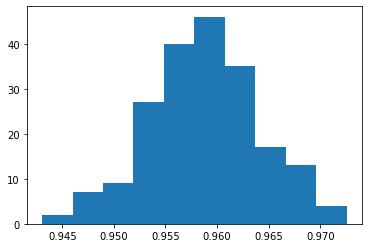

95.0 confidence interval of MCC 0.948 and 0.969
Average MCC 0.959


In [253]:
CI(df_bootstrap["CB2_RF"])